# **Submission Proyek Analisis Sentimen terhadap Ulasan Aplikasi BRImo**


## **IMPORT LIBRARY & LOAD DATA**

In [2]:
import nltk

def download_nltk_resources():
    """
    Mengecek dan mengunduh resource NLTK yang diperlukan jika belum tersedia.
    """
    required_resources = [
        ('punkt', 'tokenizers/punkt'),
        ('stopwords', 'corpora/stopwords'),
        ('wordnet', 'corpora/wordnet')
    ]

    for resource_name, resource_path in required_resources:
        try:
            nltk.data.find(resource_path)
            print(f"[✓] Resource '{resource_name}' sudah tersedia.")
        except LookupError:
            print(f"[↓] Mengunduh resource '{resource_name}'...")
            nltk.download(resource_name)

# Panggil fungsi untuk mendownload jika diperlukan
download_nltk_resources()

[✓] Resource 'punkt' sudah tersedia.
[✓] Resource 'stopwords' sudah tersedia.
[↓] Mengunduh resource 'wordnet'...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [80]:
# =========================
# 📦 Library Data Handling
# =========================
import pandas as pd
import numpy as np

# =========================
# 📊 Visualisasi
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# =========================
# 🕒 Utilities
# =========================
import warnings
import datetime as dt
import re
import string
import requests
import csv
from io import StringIO

# Ignore warning messages
warnings.filterwarnings('ignore')

# =========================
# 🔤 NLP - NLTK (Bahasa Inggris)
# =========================
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download

# Unduh resource NLTK yang diperlukan
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

# =========================
# 🗣️ NLP - Sastrawi (Bahasa Indonesia)
# =========================
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# =========================
# 🤖 Machine Learning - Scikit-Learn
# =========================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Evaluasi
from sklearn.metrics import accuracy_score, classification_report

# =========================
# 🧾 Tambahan (opsional)
# =========================
from tabulate import tabulate  # Untuk tampilan tabel yang lebih rapi (opsional)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df = pd.read_csv('/content/ulasan_brimo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   userName              20000 non-null  object
 2   userImage             20000 non-null  object
 3   content               20000 non-null  object
 4   score                 20000 non-null  int64 
 5   thumbsUpCount         20000 non-null  int64 
 6   reviewCreatedVersion  16695 non-null  object
 7   at                    20000 non-null  object
 8   replyContent          19448 non-null  object
 9   repliedAt             19448 non-null  object
 10  appVersion            16695 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


## **DATA PREPARATION**

In [91]:
# Pemeriksaan Awal Kualitas DataFrame

# 1. Tipe data tiap kolom
print("📌 Tipe Data per Kolom:")
print(df.dtypes)
print("\n" + "="*50)

# 2. Jumlah missing values
print("📌 Jumlah Missing Values per Kolom:")
print(df.isna().sum())
print("\n" + "="*50)

# 3. Jumlah data duplikat
duplicate_count = df.duplicated().sum()
print(f"📌 Jumlah Data Duplikat: {duplicate_count}")
print("\n" + "="*50)

# 4. Jumlah nilai unik per kolom
print("📌 Jumlah Nilai Unik per Kolom:")
print(df.nunique())
print("\n" + "="*50)

# 5. Contoh nilai unik untuk kolom kategorikal (opsional)
print("📌 Contoh Nilai Unik (Kolom Kategorikal):")
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    print(f"- {col}: {df[col].unique()[:5]}")  # Tampilkan 5 contoh pertama


📌 Tipe Data per Kolom:
reviewId                object
userName                object
userImage               object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
replyContent            object
repliedAt               object
appVersion              object
dtype: object

📌 Jumlah Missing Values per Kolom:
reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    3305
at                         0
replyContent             552
repliedAt                552
appVersion              3305
dtype: int64

📌 Jumlah Data Duplikat: 0

📌 Jumlah Nilai Unik per Kolom:
reviewId                20000
userName                 1995
userImage                2001
content                 12912
score                       5
thumbsUpCount              43
reviewCreatedVe

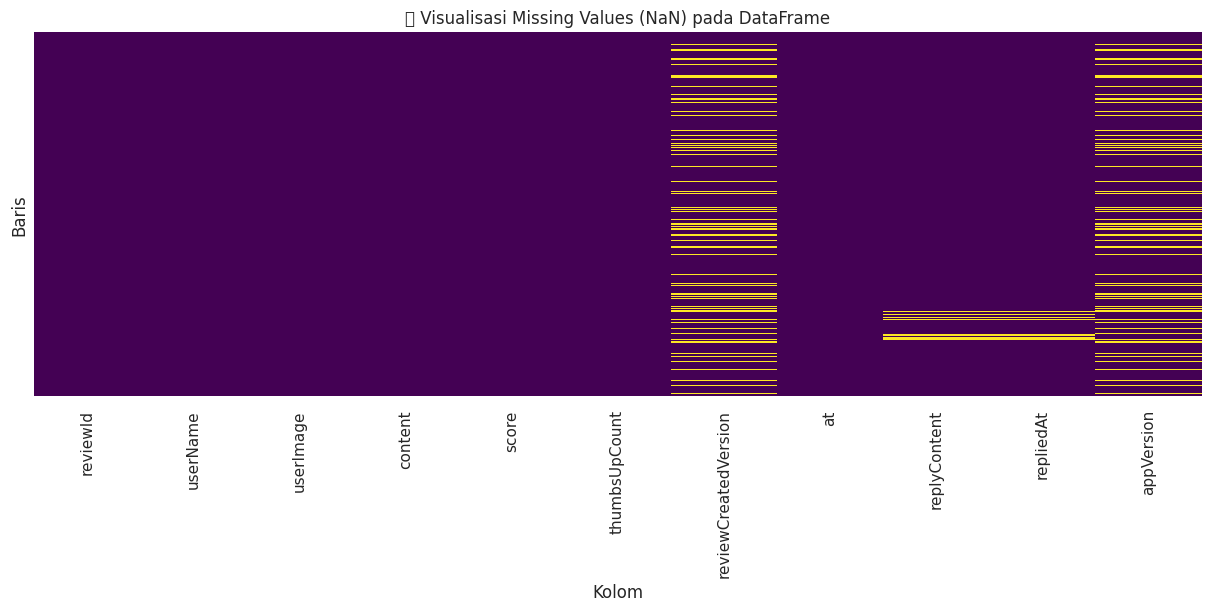

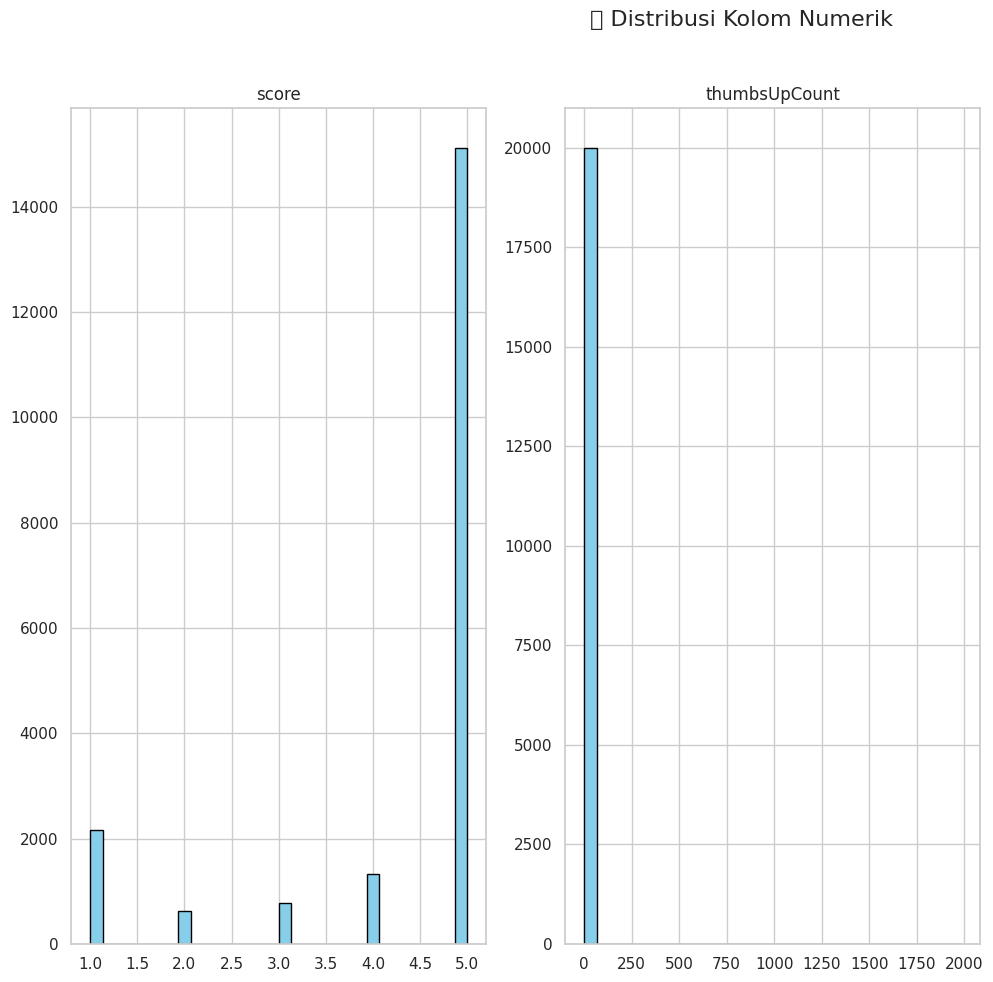

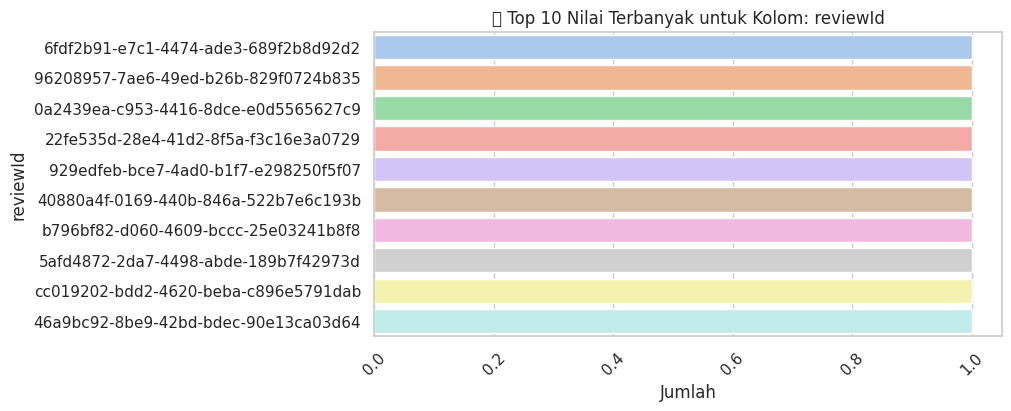

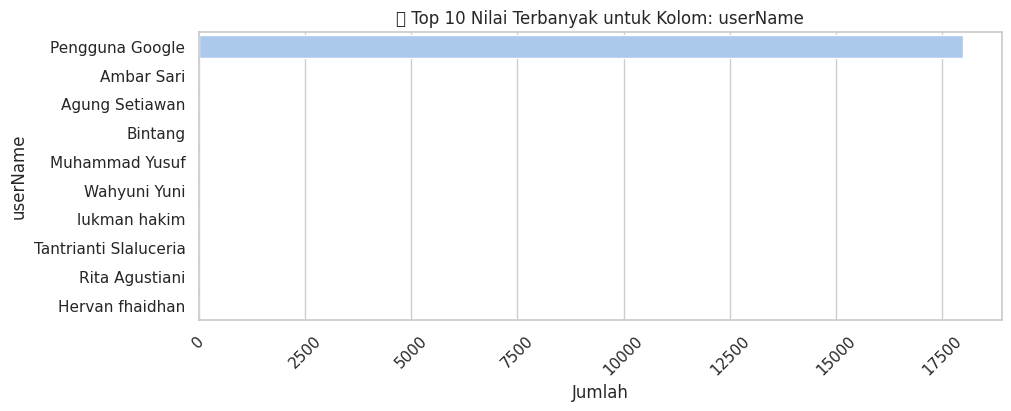

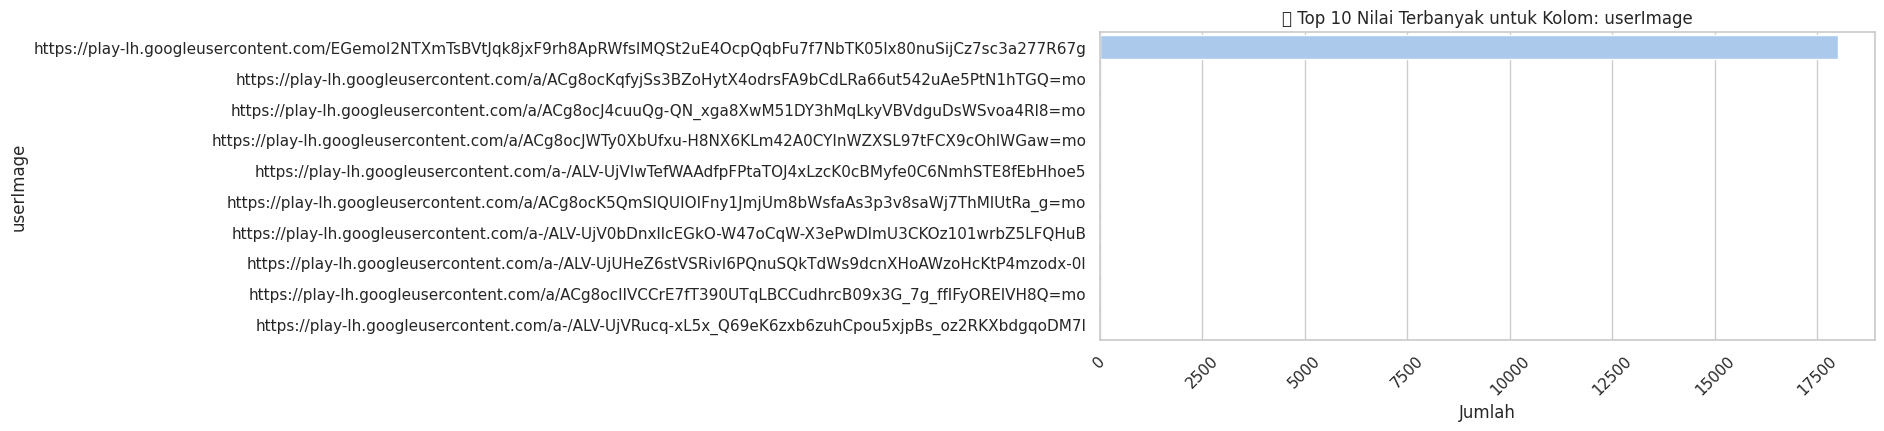

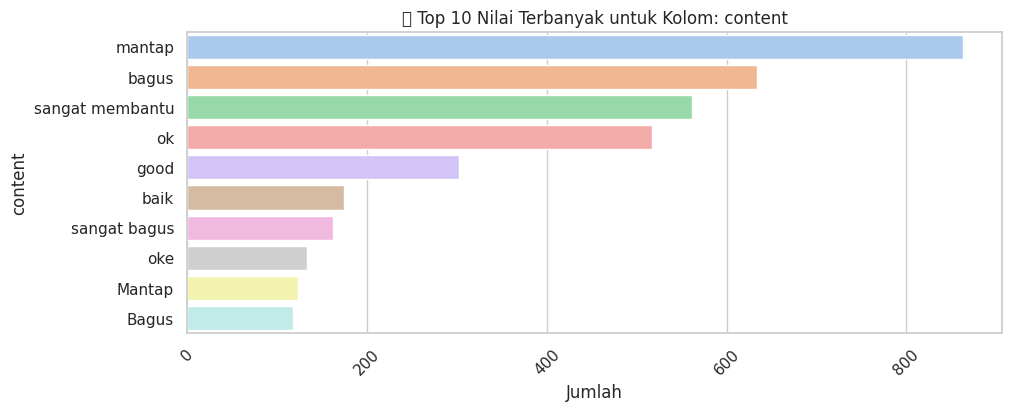

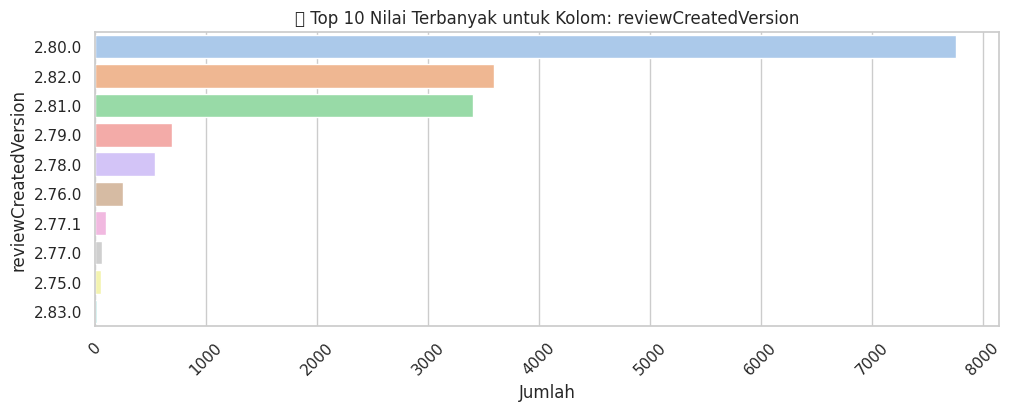

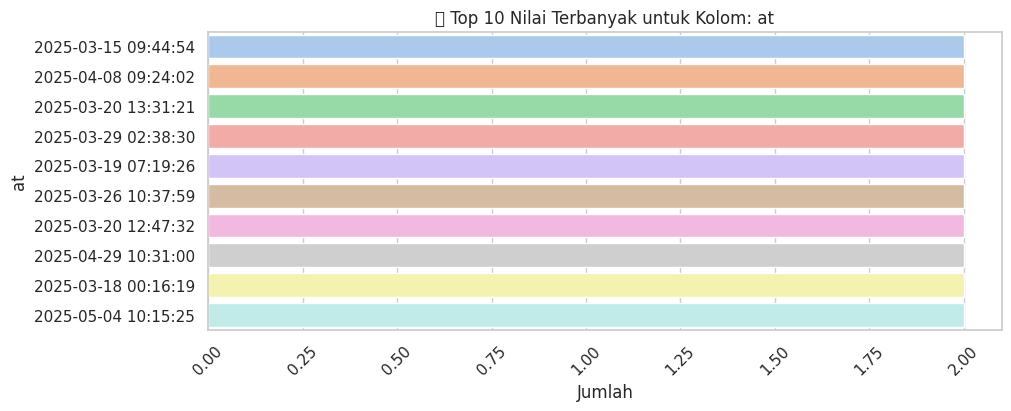

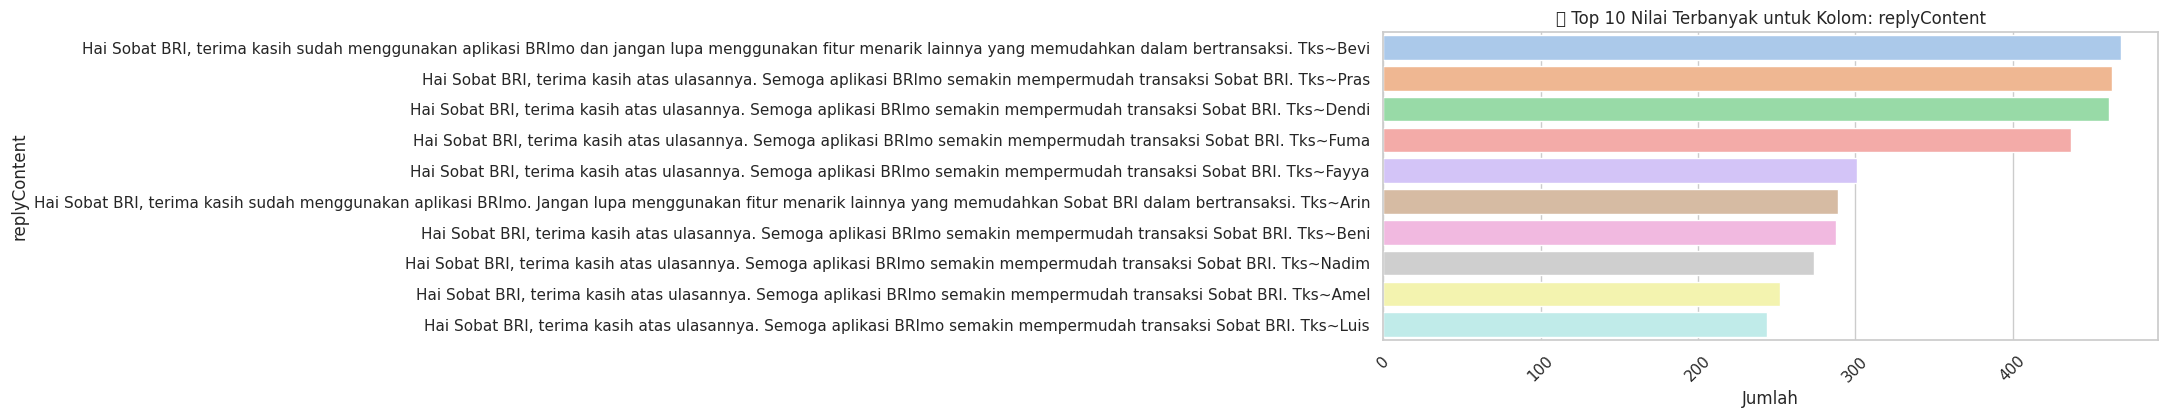

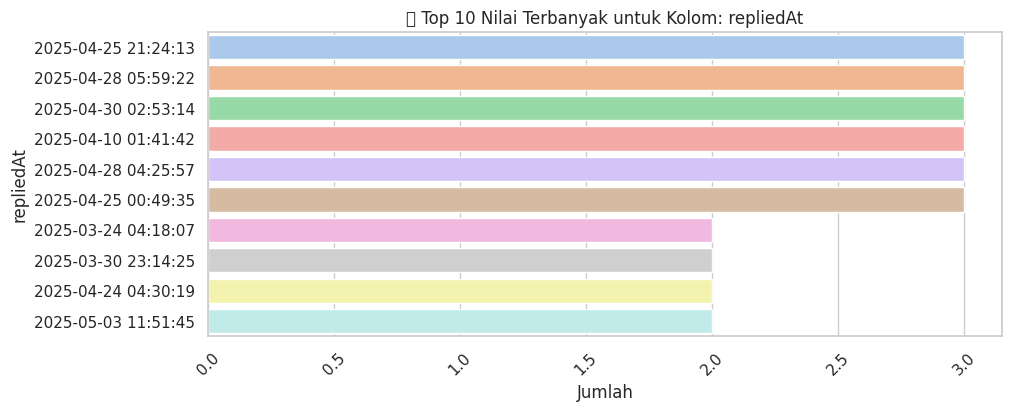

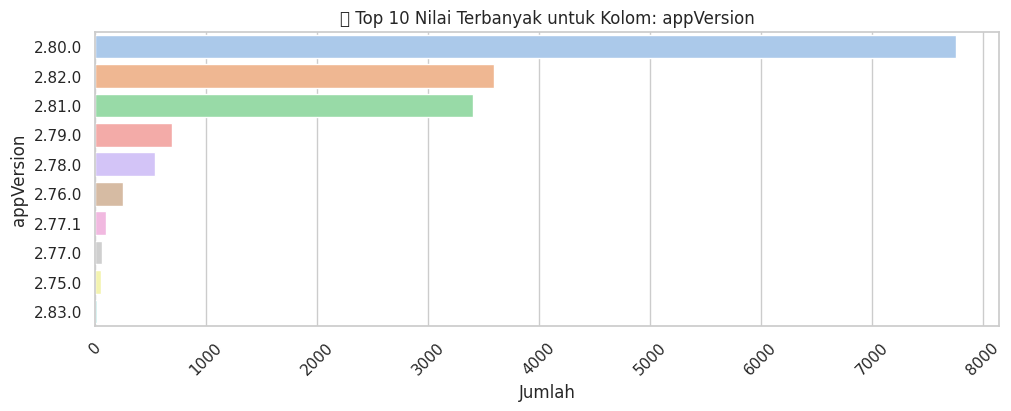

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set tema visualisasi
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Heatmap Missing Values
plt.figure(figsize=(12, 6), constrained_layout=True)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("🔍 Visualisasi Missing Values (NaN) pada DataFrame")
plt.xlabel("Kolom")
plt.ylabel("Baris")
plt.show()

# 2. Histogram Kolom Numerik
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

if len(numerical_cols) > 0:
    df[numerical_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black', layout=(len(numerical_cols)//3 + 1, 3))
    plt.suptitle("📊 Distribusi Kolom Numerik", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("⚠️ Tidak ada kolom numerik untuk divisualisasikan.")

# 3. Diagram Batang Kolom Kategorikal (Top 10 Nilai Terbanyak)
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    plt.figure(figsize=(10, 4), constrained_layout=True)
    top_values = df[col].value_counts().nlargest(10)
    sns.barplot(x=top_values.values, y=top_values.index, palette="pastel")
    plt.title(f"📦 Top 10 Nilai Terbanyak untuk Kolom: {col}")
    plt.xlabel("Jumlah")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.show()

## **PRE-PROCESSING TEXT**

### ***Fungsi Pembersihan Teks (Cleaning)***

In [13]:
#Membersihkan teks dari karakter tidak penting
def cleaning_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'\bRT\b', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

### ***Case Folding***

In [14]:
def casefolding_text(text):
    return text.lower()

### ***Tokenisasi***

In [15]:
def tokenizing_text(text):
    return word_tokenize(text)

### ***Stopword Removal / Filtering***

In [16]:
def filtering_text(tokens):
    stop_words_id = set(stopwords.words('indonesian'))
    stop_words_en = set(stopwords.words('english'))

    custom_stopwords = {
        'iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa',
        'loh','kah','woi','woii','woy'
    }

    stop_words = stop_words_id.union(stop_words_en).union(custom_stopwords)

    return [word for word in tokens if word not in stop_words]

### ***Stemming***

In [17]:
def stemming_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]

    return ' '.join(stemmed_words)

### ***Konversi Kembali ke Kalimat***

In [18]:
def to_sentence(words):
    return ' '.join(words)

### ***Slang Words Dictionary dan Fungsi Perbaikan***

In [19]:
slangwords = {
    "gg": "bagus", "mantul": "mantap betul", "kece": "keren", "sip": "baik", "ok": "oke",
    "okeh": "oke", "mayan": "lumayan", "zonk": "mengecewakan", "auto": "otomatis",
    "topup": "isi saldo", "withdraw": "tarik saldo", "saldo": "jumlah uang",
    "cashback": "pengembalian dana", "promo": "diskon", "voucher": "kupon diskon",
    "limit": "batas transaksi", "taptap": "tap kartu", "jeniuspay": "pembayaran Jenius",
    "m-card": "kartu utama", "e-card": "kartu virtual", "x-card": "kartu tambahan",
    "flexi": "fleksibel", "splitbill": "bagi tagihan", "paylater": "bayar nanti",
    "cashtag": "nama pengguna Jenius", "nomor rekening": "nomor akun", "mauin": "ingin",
    "lemot": "lambat", "delay": "tertunda", "bug": "kesalahan sistem", "error": "gagal",
    "crash": "berhenti mendadak", "otp": "kode verifikasi", "token": "kode keamanan",
    "update": "pembaruan", "upgrade": "peningkatan layanan", "downgrade": "penurunan layanan",
    "banned": "diblokir", "verif": "verifikasi", "respon": "tanggapan", "fastrespon": "tanggapan cepat",
    "slowrespon": "tanggapan lambat", "cs": "layanan pelanggan", "admin": "pengelola",
    "trusted": "terpercaya", "uninstall": "hapus aplikasi", "install": "pasang aplikasi",
    "subscribe": "berlangganan", "unsubscribe": "berhenti langganan"
}

def fix_slangwords(text):
    words = text.split()
    return ' '.join(slangwords.get(word.lower(), word) for word in words)

### ***Pembersihan DataFrame***

In [28]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [30]:
def preprocess_text_clean(df, text_column):
    clean_df = df.copy()

    clean_df['text_clean'] = clean_df[text_column].apply(cleaning_text)
    clean_df['text_casefold'] = clean_df['text_clean'].apply(casefolding_text)
    clean_df['text_slangfixed'] = clean_df['text_casefold'].apply(fix_slangwords)
    clean_df['text_tokenized'] = clean_df['text_slangfixed'].apply(tokenizing_text)
    clean_df['text_filtered'] = clean_df['text_tokenized'].apply(filtering_text)
    clean_df['text_final'] = clean_df['text_filtered'].apply(to_sentence)

    return clean_df

In [43]:
clean_df = preprocess_text_clean(df, 'content')
clean_df[['text_clean', 'text_casefold', 'text_slangfixed', 'text_tokenized', 'text_filtered', 'text_final']].head()

,text_clean,text_casefold,text_slangfixed,text_tokenized,text_filtered,text_final
0,bagus,bagus,bagus,[bagus],[bagus],bagus
1,instan banget,instan banget,instan banget,"[instan, banget]","[instan, banget]",instan banget
2,ok bagus,ok bagus,oke bagus,"[oke, bagus]","[oke, bagus]",oke bagus
3,BRImo mempermudah transaksitransaksi kami bona...,brimo mempermudah transaksitransaksi kami bona...,brimo mempermudah transaksitransaksi kami bona...,"[brimo, mempermudah, transaksitransaksi, kami,...","[brimo, mempermudah, transaksitransaksi, bonaf...",brimo mempermudah transaksitransaksi bonafit p...
4,Keren,keren,keren,[keren],[keren],keren


In [90]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefold,text_slangfixed,text_tokenized,text_filtered,text_final,polarity_score,polarity,text_length
0,75cdc22c-2d6f-4c2d-a644-ef6f4037590a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus,5,0,NaN,2025-05-06 15:53:32,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:26:46,NaN,bagus,bagus,bagus,[bagus],[bagus],bagus,-2,neutral,1
1,3e79831d-0982-4b4a-bf47-43641e91abd1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,instan banget,5,0,NaN,2025-05-06 15:50:13,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:25:42,NaN,instan banget,instan banget,instan banget,"[instan, banget]","[instan, banget]",instan banget,1,positive,2
2,25b529b2-9a4e-41e7-941c-932fda6ee653,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ok bagus,5,0,2.82.0,2025-05-06 15:49:46,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:27:55,2.82.0,ok bagus,ok bagus,oke bagus,"[oke, bagus]","[oke, bagus]",oke bagus,0,positive,2
3,c62d660e-fee1-454f-b1d3-a4251e082c90,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,BRImo mempermudah transaksi-transaksi kami.. b...,5,0,2.83.0,2025-05-06 15:49:06,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:26:21,2.83.0,BRImo mempermudah transaksitransaksi kami bona...,brimo mempermudah transaksitransaksi kami bona...,brimo mempermudah transaksitransaksi kami bona...,"[brimo, mempermudah, transaksitransaksi, kami,...","[brimo, mempermudah, transaksitransaksi, bonaf...",brimo mempermudah transaksitransaksi bonafit p...,-1,neutral,6
4,3d49d286-2728-458e-8510-36ccfc403845,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Keren,5,0,NaN,2025-05-06 15:47:08,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:27:18,NaN,Keren,keren,keren,[keren],[keren],keren,0,positive,1


### ***MENYIMPAN DATASET HASIL PREPROCESSING***

#### ***Format CSV***

In [98]:
clean_df.to_csv('cleaned_data.csv', index=False)
print("Dataset telah disimpan sebagai 'cleaned_data.csv'")

Dataset telah disimpan sebagai 'cleaned_data.csv'


#### ***Format JSON***

In [94]:
clean_df.to_json('cleaned_data.json', orient='records', lines=True)
print("Dataset telah disimpan sebagai 'cleaned_data.json'")

Dataset telah disimpan sebagai 'cleaned_data.json'


## **PELABELAN DATA (LEXICON)**

### ***Load Lexicon Positive***

In [45]:
lexicon_positive = {}

url_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
response = requests.get(url_positive)
reader = csv.reader(StringIO(response.text), delimiter=',')

for row in reader:
    lexicon_positive[row[0]] = int(row[1])

### ***Load Lexicon Negative***

In [46]:
lexicon_negative = {}

url_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
response = requests.get(url_negative)
reader = csv.reader(StringIO(response.text), delimiter=',')

for row in reader:
    lexicon_negative[row[0]] = int(row[1])


### ***Fungsi Pelabelan Lexicon***

In [47]:
def pelabelan_lexicon_indonesia(tokens):
    score = 0

    # Hitung skor positif
    for word in tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]

    # Hitung skor negatif
    for word in tokens:
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Tentukan polaritas berdasarkan skor
    if score >= 0:
        polarity = 'positive'
    elif score <= -3:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

### ***Terapkan ke Data dan Tampilkan Hasil***

In [50]:
# Terapkan fungsi ke kolom token yang sudah difilter (hasil tokenizing + stopword removal)
results = clean_df['text_filtered'].apply(pelabelan_lexicon_indonesia)

# Pisahkan hasil ke dua kolom
clean_df['polarity_score'] = results.apply(lambda x: x[0])
clean_df['polarity'] = results.apply(lambda x: x[1])

# Cek distribusi label
print(clean_df['polarity'].value_counts())

polarity
positive    15297
negative     2475
neutral      2228
Name: count, dtype: int64


## **Exploratory Data Analysis (EDA)**

### ***Tampilkan 5 Baris Pertama***

In [51]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefold,text_slangfixed,text_tokenized,text_filtered,text_final,polarity_score,polarity
0,75cdc22c-2d6f-4c2d-a644-ef6f4037590a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus,5,0,NaN,2025-05-06 15:53:32,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:26:46,NaN,bagus,bagus,bagus,[bagus],[bagus],bagus,-2,neutral
1,3e79831d-0982-4b4a-bf47-43641e91abd1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,instan banget,5,0,NaN,2025-05-06 15:50:13,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:25:42,NaN,instan banget,instan banget,instan banget,"[instan, banget]","[instan, banget]",instan banget,1,positive
2,25b529b2-9a4e-41e7-941c-932fda6ee653,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ok bagus,5,0,2.82.0,2025-05-06 15:49:46,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:27:55,2.82.0,ok bagus,ok bagus,oke bagus,"[oke, bagus]","[oke, bagus]",oke bagus,0,positive
3,c62d660e-fee1-454f-b1d3-a4251e082c90,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,BRImo mempermudah transaksi-transaksi kami.. b...,5,0,2.83.0,2025-05-06 15:49:06,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:26:21,2.83.0,BRImo mempermudah transaksitransaksi kami bona...,brimo mempermudah transaksitransaksi kami bona...,brimo mempermudah transaksitransaksi kami bona...,"[brimo, mempermudah, transaksitransaksi, kami,...","[brimo, mempermudah, transaksitransaksi, bonaf...",brimo mempermudah transaksitransaksi bonafit p...,-1,neutral
4,3d49d286-2728-458e-8510-36ccfc403845,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Keren,5,0,NaN,2025-05-06 15:47:08,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-05-06 17:27:18,NaN,Keren,keren,keren,[keren],[keren],keren,0,positive


### ***Visualisasi Distribusi Sentimen***

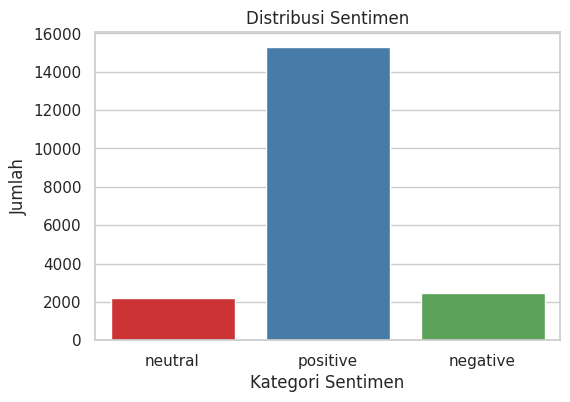

In [52]:
plt.figure(figsize=(6, 4))
sns.countplot(x='polarity', data=clean_df, palette='Set1')
plt.title('Distribusi Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah')
plt.show()

### ***Distribusi Panjang Teks***

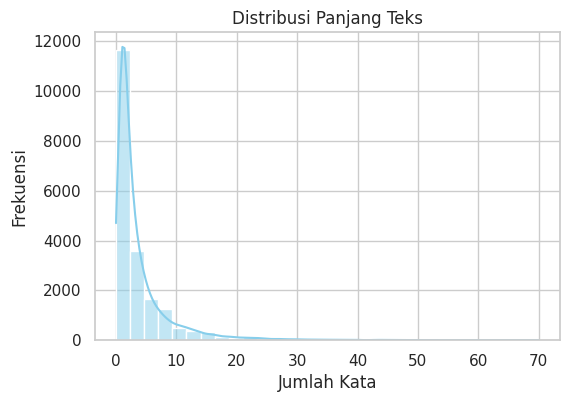

In [53]:
# Hitung panjang teks dari kolom token
clean_df['text_length'] = clean_df['text_filtered'].apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(clean_df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

### *** Nilai Polarity Score***

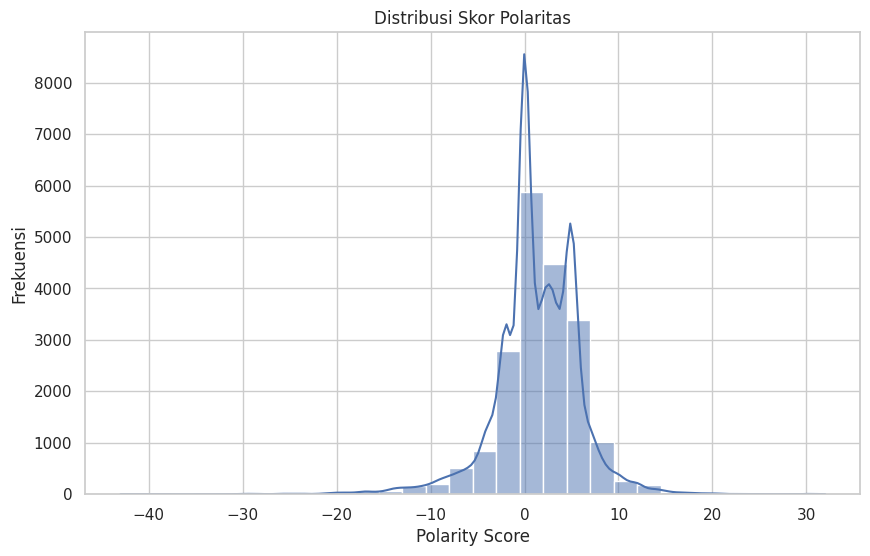

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)
plt.title('Distribusi Skor Polaritas')
plt.xlabel('Polarity Score')
plt.ylabel('Frekuensi')
plt.show()

### ***Pie Chart Distribusi Kategori Sentimen***

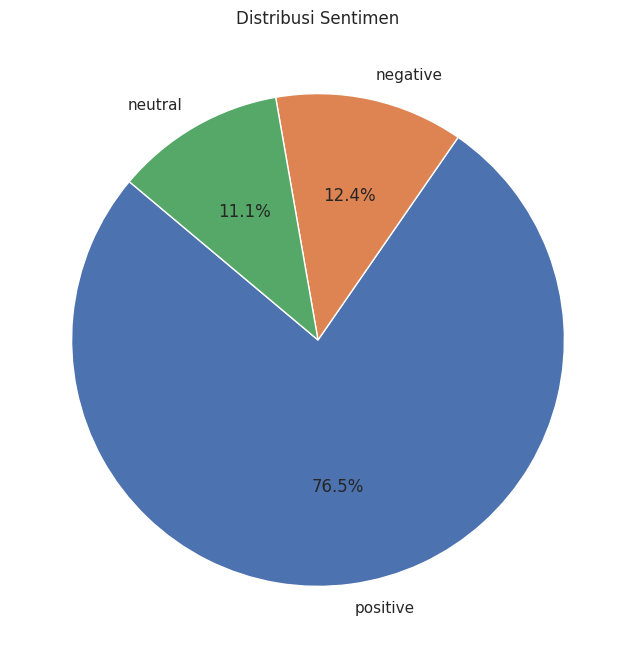

In [56]:
polarity_counts = clean_df['polarity'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Sentimen')
plt.show()

### ***Visualisasi 20 Kata Paling Sering Muncul (TF-IDF)***

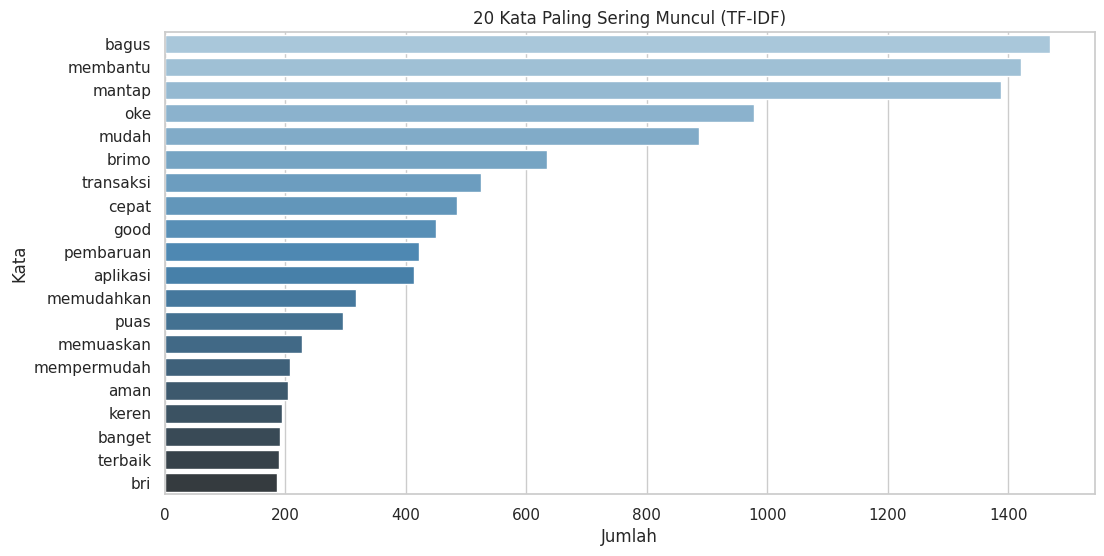

In [57]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_final'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_sum = tfidf_df.sum().reset_index(name='jumlah')
tfidf_sum = tfidf_sum.rename(columns={'index': 'kata'})
tfidf_top20 = tfidf_sum.sort_values('jumlah', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='jumlah', y='kata', data=tfidf_top20, palette='Blues_d')
plt.title('20 Kata Paling Sering Muncul (TF-IDF)')
plt.xlabel('Jumlah')
plt.ylabel('Kata')
plt.show()

## **MODELING**

### ***TF-IDF Vectorizer dan Label Encoding***

In [58]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(clean_df['text_final'])

# Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(clean_df['polarity'])

# Mapping Label
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


### ***Naive Bayes Classifier***

In [59]:
# Split 80/20
X_train_nbc, X_test_nbc, y_train_nbc, y_test_nbc = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Model & Training
nbc_model = MultinomialNB()
nbc_model.fit(X_train_nbc, y_train_nbc)

# Prediksi & Evaluasi
y_pred_nbc = nbc_model.predict(X_test_nbc)
print("🔹 Naive Bayes Classifier")
print("Accuracy:", accuracy_score(y_test_nbc, y_pred_nbc))
print("\nClassification Report:\n", classification_report(y_test_nbc, y_pred_nbc, target_names=label_encoder.classes_))


🔹 Naive Bayes Classifier
Accuracy: 0.8465

Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.34      0.48       495
     neutral       0.95      0.42      0.58       446
    positive       0.85      0.99      0.91      3059

    accuracy                           0.85      4000
   macro avg       0.86      0.58      0.66      4000
weighted avg       0.85      0.85      0.82      4000



### ***Logistic Regression***

In [60]:
# Split 70/30
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Model & Training
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Prediksi & Evaluasi
y_pred_lr = lr_model.predict(X_test_lr)
print("🔹 Logistic Regression")
print("Accuracy:", accuracy_score(y_test_lr, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test_lr, y_pred_lr, target_names=label_encoder.classes_))


🔹 Logistic Regression
Accuracy: 0.9193333333333333

Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.75      0.79       743
     neutral       0.94      0.61      0.74       668
    positive       0.93      0.99      0.96      4589

    accuracy                           0.92      6000
   macro avg       0.90      0.79      0.83      6000
weighted avg       0.92      0.92      0.91      6000



### ***Support Vector Machine***

In [79]:
# Split 60/40
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y)

# Model & Training
svm_model = LinearSVC()
svm_model.fit(X_train_svm, y_train_svm)

# Prediksi & Evaluasi
y_pred_svm = svm_model.predict(X_test_svm)
print("🔹 Support Vector Machine")
print("Accuracy:", accuracy_score(y_test_svm, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test_svm, y_pred_svm, target_names=label_encoder.classes_))


🔹 Support Vector Machine
Accuracy: 0.93425

Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.84      0.84       990
     neutral       0.93      0.65      0.76       891
    positive       0.95      0.99      0.97      6119

    accuracy                           0.93      8000
   macro avg       0.91      0.83      0.86      8000
weighted avg       0.93      0.93      0.93      8000



### ***Perbandingan Akurasi Model***

In [78]:
# Hitung akurasi
acc_nbc_train = accuracy_score(y_train_nbc, nbc_model.predict(X_train_nbc))
acc_nbc_test = accuracy_score(y_test_nbc, y_pred_nbc)

acc_lr_train = accuracy_score(y_train_lr, lr_model.predict(X_train_lr))
acc_lr_test = accuracy_score(y_test_lr, y_pred_lr)

acc_svm_train = accuracy_score(y_train_svm, svm_model.predict(X_train_svm))
acc_svm_test = accuracy_score(y_test_svm, y_pred_svm)

# DataFrame perbandingan
model_comparison = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM'],
    'Feature Extraction': ['TF-IDF'] * 3,
    'Split Ratio (Train/Test)': ['80/20', '70/30', '60/40'],
    'Train Accuracy': [acc_nbc_train, acc_lr_train, acc_svm_train],
    'Test Accuracy': [acc_nbc_test, acc_lr_test, acc_svm_test]
})

print(tabulate(model_comparison, headers='keys', tablefmt='github', showindex=False))


| Model               | Feature Extraction   | Split Ratio (Train/Test)   |   Train Accuracy |   Test Accuracy |
|---------------------|----------------------|----------------------------|------------------|-----------------|
| Naive Bayes         | TF-IDF               | 80/20                      |         0.880062 |        0.8465   |
| Logistic Regression | TF-IDF               | 70/30                      |         0.9445   |        0.919333 |
| SVM                 | TF-IDF               | 60/40                      |         0.989083 |        0.93425  |


### ***Simpan Model & TF-IDF Vectorizer dan Label Encoder***

In [96]:
import joblib

# Simpan model klasifikasi
joblib.dump(nbc_model, 'naive_bayes_model.joblib')
joblib.dump(lr_model, 'logistic_regression_model.joblib')
joblib.dump(svm_model, 'svm_model.joblib')

# Simpan TF-IDF Vectorizer dan Label Encoder
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

print("✅ Semua model dan objek preprocessing berhasil disimpan!")

✅ Semua model dan objek preprocessing berhasil disimpan!


In [97]:
from google.colab import files
files.download('naive_bayes_model.joblib')
files.download('logistic_regression_model.joblib')
files.download('svm_model.joblib')
files.download('tfidf_vectorizer.joblib')
files.download('label_encoder.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **INFERENCE**

### ***Definisi Fungsi Prediksi Multi-Model***

In [63]:
def predict_sentiment_all_models(texts, models_dict, vectorizer, label_encoder):
    """
    Melakukan prediksi sentimen dari beberapa model sekaligus.

    Args:
        texts (list of str): Kalimat-kalimat yang akan diprediksi.
        models_dict (dict): Dictionary berisi nama model sebagai key dan objek model sebagai value.
        vectorizer: Objek vectorizer (misalnya TF-IDF).
        label_encoder: Label encoder untuk mengubah label numerik menjadi label asli.

    Returns:
        dict: Dictionary berisi hasil prediksi dari setiap model.
    """
    results = {}

    for model_name, model in models_dict.items():
        preds = []
        for text in texts:
            text_clean = text.lower()
            text_vector = vectorizer.transform([text_clean])
            pred = model.predict(text_vector)
            label = label_encoder.inverse_transform(pred)[0]
            preds.append(label)
        results[model_name] = preds

    return results

### ***Persiapan Model dan Sample Input***

In [75]:
models = {
    'Naive Bayes': nbc_model,
    'Logistic Regression': lr_model,
    'SVM': svm_model
}

sample_text = [
    "Pelayanan sangat buruk dan responnya lambat.",
    "Saya suka tampilannya yang baru, sangat menarik!",
    "Aplikasi ini error terus setiap kali dibuka.",
    "Fitur-fiturnya lengkap dan mudah diakses.",
    "Kurang puas, banyak bug yang belum diperbaiki."
]

### ***Melakukan Prediksi Sentimen (Prediksi sentimen untuk setiap model)***

In [69]:
results = predict_sentiment_all_models(sample_text, models, tfidf_vectorizer, label_encoder)

### ***Menyusun dan Menampilkan Hasil Prediksi***

In [74]:
df_hasil = pd.DataFrame(results)
df_hasil.insert(0, 'Text', sample_text)

print("Hasil Prediksi Sentimen dari Berbagai Model:")
df_hasil

Hasil Prediksi Sentimen dari Berbagai Model:


,Text,Naive Bayes,Logistic Regression,SVM
0,Aplikasinya sangat membantu dan mudah digunakan.,positive,positive,positive
1,"Belum kucoba semua fiturnya, tampaknya biasa s...",positive,positive,positive
2,Proses login ribet dan tidak dapat verifikasi.,positive,negative,negative


## **Simpan dan Tampilkan Daftar Dependencies sebagai Tabel**

In [99]:
# Simpan daftar dependensi ke file requirements.txt
!pip freeze > requirements.txt

In [100]:
with open('requirements.txt', 'r') as file:
    lines = file.readlines()

# bersihkan dan pisahkan nama paket dan versinya
packages = [line.strip().split('==') for line in lines if '==' in line]
df_requirements = pd.DataFrame(packages, columns=['Package', 'Version'])

# tampilkan tabel
print("📦 Daftar Dependency Environment (requirements.txt):")
display(df_requirements.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
).hide(axis="index"))

📦 Daftar Dependency Environment (requirements.txt):


Package,Version
absl-py,1.4.0
accelerate,1.6.0
aiohappyeyeballs,2.6.1
aiohttp,3.11.15
aiosignal,1.3.2
alabaster,1.0.0
albucore,0.0.24
albumentations,2.0.6
ale-py,0.11.0
altair,5.5.0
